In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
df = pd.read_csv('UsArrests.csv')

In [4]:
df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


##### Summarise statistical properties of the columns:

In [7]:
stats = df.describe()
selected_stats = stats.loc[['mean', 'std', 'min', 'max']].transpose()
selected_stats

,mean,std,min,max
Murder,7.788,4.355510,0.8,17.4
Assault,170.760,83.337661,45.0,337.0
UrbanPop,65.540,14.474763,32.0,91.0
Rape,21.232,9.366385,7.3,46.0


##### Determine if we have any mssing values, and which features theses occur for:

In [9]:
# find and count missing values
missing = df.isnull().sum()
relevant_missing = pd.DataFrame(missing, columns=["missing"])
relevant_missing

,missing
City,0
Murder,0
Assault,0
UrbanPop,0
Rape,0


In [ ]:
# There is no missing values in our dataset

##### It is often useful to determine the type of each variable. We see that we are working predominantly with continuous variables:

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


##### To visualise the distribution of the observations for each feature, we plot a histogram using Pandas's .hist() function:

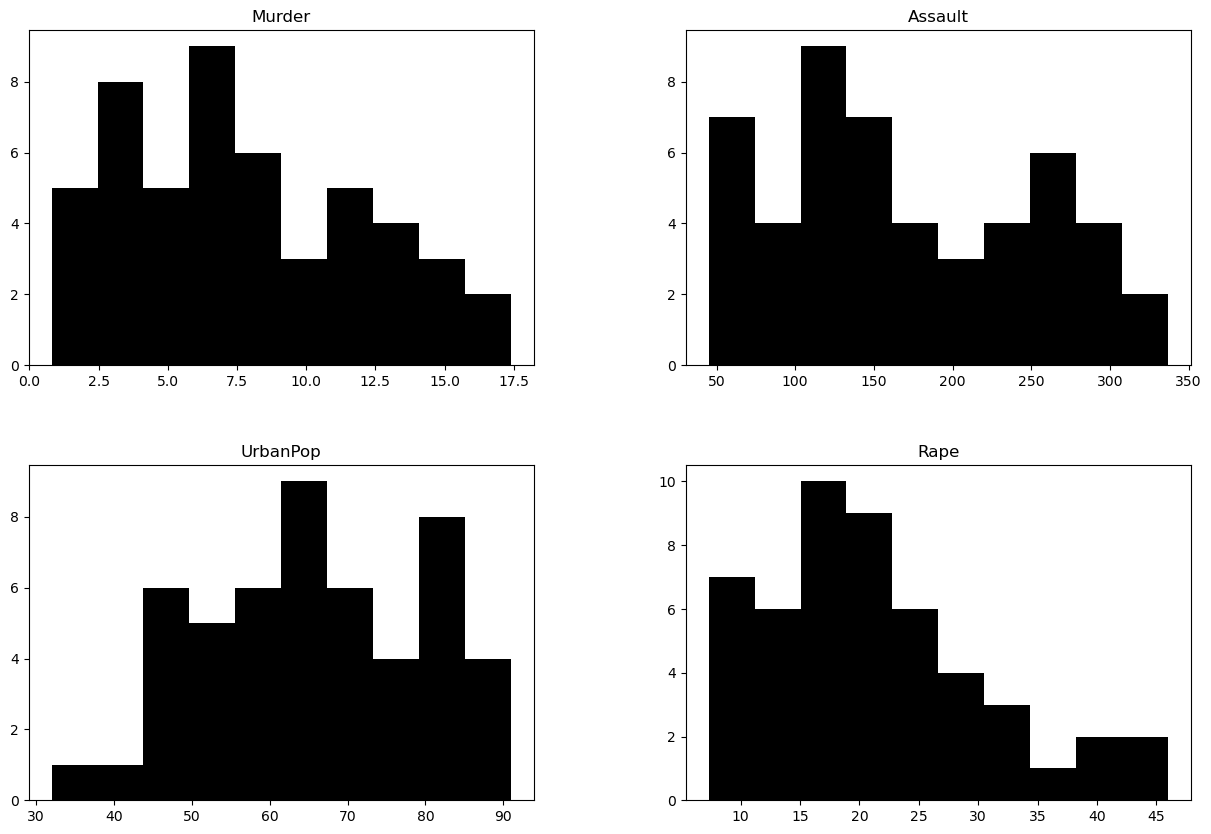

In [12]:
# Plot histograms
histograms = df.hist(color='black', grid=False, figsize=(15, 10)) #This can also be done for each column individually by calling hist on that column
plt.show()


##### We can compile the tabular information we have so far into a single dataframe:

In [ ]:
# Create summary table
frames = [relevant_missing,selected_stats]
summary = pd.concat(frames, axis=1)
summary.rename(columns = {0:"missing"}, inplace = True)
summary.to_csv('summary.csv', index=True) 
summary


## Correlation Analysis

In [16]:
city = df.index
corr_df = df.drop(["City"],axis=1).corr()
labels =corr_df.columns

correlations = corr_df.corr()

<AxesSubplot:>

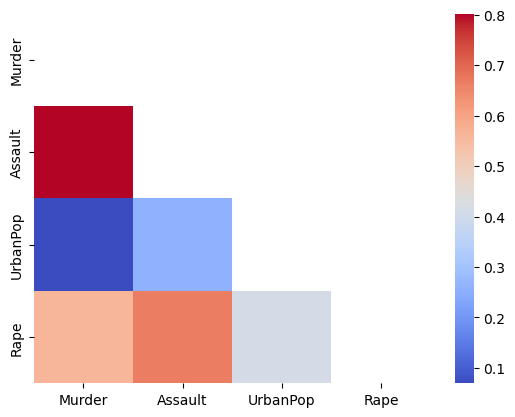

In [22]:
import seaborn as sns
mask_ut=np.triu(np.ones(corr_df.shape)).astype(bool)
sns.heatmap(corr_df, mask=mask_ut, cmap="coolwarm")

##### In the plot, there is a linear correlation between strongly correlated variables: those coloured in either dark red or dark blue. Variables which are positively correlated are red: an increase in one corresponds to an increase in the other, while negatively correlated variables are blue: a decrease in one means an increase in the other.

##### From the correlation plot, it is evident that Murder has very strong positive correlation with Assault and a revaltively strong correlation with rape, it also has a very weak correlation with Urbanpop. Assault has a strong correlation with Rape, and weak correlation with Urbanpop. 

## PCA

In [23]:
from sklearn.decomposition import PCA #run again if it does not converge the first time

np.set_printoptions(precision=2)

X = df.drop(["City"],axis=1).values.squeeze()

pca = PCA()

X_trans = pca.fit_transform(X)

df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,64.802164,11.448007,-2.494933,2.407901
1,92.827450,17.982943,20.126575,-4.094047
2,124.068216,-8.830403,-1.687448,-4.353685
3,18.340035,16.703911,0.210189,-0.520994
4,107.422953,-22.520070,6.745873,-2.811826


In [24]:
std = df_pca.describe().transpose()["std"]
print(f"Standard deviation: {std.values}")

Standard deviation: [83.73 14.21  6.49  2.48]


In [25]:
print(f"Proportion of Variance Explained: {pca.explained_variance_ratio_}")

Proportion of Variance Explained: [9.66e-01 2.78e-02 5.80e-03 8.49e-04]


In [26]:
print(f"Cumulative Proportion: {np.cumsum(pca.explained_variance_)}")

Cumulative Proportion: [7011.11 7213.11 7255.22 7261.38]


In [29]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = city[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

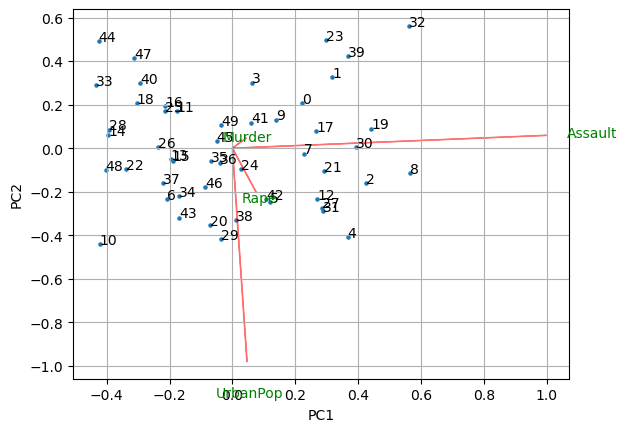

In [31]:
biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(city))
plt.show()

##### Each point on a biplot is the projected observation, transformed from the original data. The importance of each feature is indicated by the length of the arrows on the biplot. This corresponds to the magnitude of the values in the eigenvectors. From this biplot, we see that Assault and Urbanpop is the most important features.

In [32]:
# Feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

pc1 = abs( pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.042,0.045
1,Assault,0.995,0.059
2,UrbanPop,0.046,0.977
3,Rape,0.075,0.201


#### We see that the Assault has by far the highest importance in the first principle component, while several features are relatively important for the second component: Rape the most important at around 0.977 These observations agree with those deduced from the biplot. If we refer to our summarised statistics from earlier on, the mean values for these features are much larger numbers than those for the other features. It is possible that because of this, these features 'swamp' the others, which results in them being ignored.

In [33]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

std_pca = PCA()
X_std_trans = std_pca.fit_transform(X_std)

df_std_pca = pd.DataFrame(X_std_trans)
df_std_pca.head()

,0,1,2,3
0,0.986,1.133,-0.444,0.156
1,1.950,1.073,2.040,-0.439
2,1.763,-0.746,0.055,-0.835
3,-0.141,1.120,0.115,-0.183
4,2.524,-1.543,0.599,-0.342


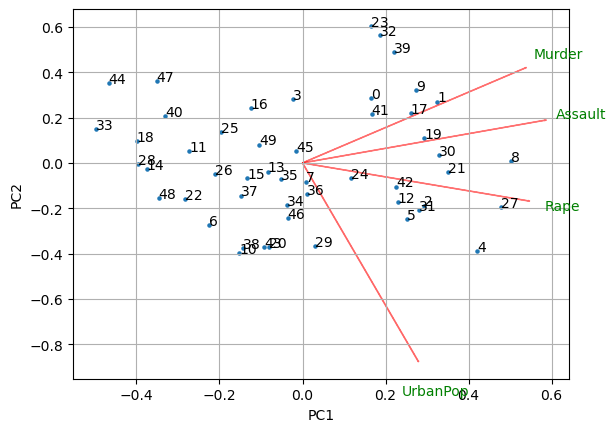

In [34]:
biplot(X_std_trans[:,0:2],np.transpose(std_pca.components_[0:2, :]),list(labels))
plt.show()

#### We see that the standardised data results in far more variables being utilised to explain the variance, as the large numbers no longer dominate it. We also see that the the different features cluster together in groups.

In [35]:
# Feature importance

pc1 = abs( std_pca.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( std_pca.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(labels)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop,0.278,0.873
3,Rape,0.543,0.167


#### Inspecting the feature importance now, we see that most of the variables contribute fairly evenly, with only some with low importance.

Text(0.5, 1.0, 'Cumulative Explained Variance')

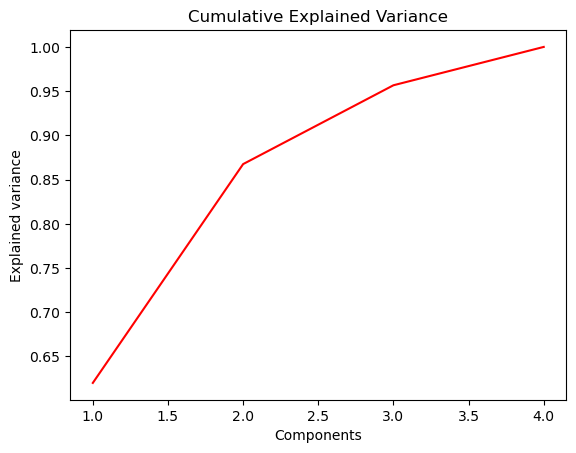

In [37]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(std_pca.explained_variance_ratio_ )+1),
         np.cumsum(std_pca.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")

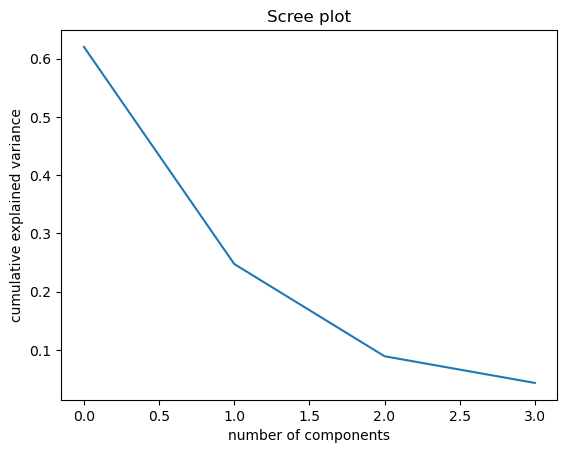

In [38]:
# Scree plot
plt.plot(std_pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

In [39]:
pca_df = pd.DataFrame(X_std_trans[:,0:5], index = df.index)
pca_df.head()

,0,1,2,3
0,0.986,1.133,-0.444,0.156
1,1.950,1.073,2.040,-0.439
2,1.763,-0.746,0.055,-0.835
3,-0.141,1.120,0.115,-0.183
4,2.524,-1.543,0.599,-0.342


## Hierarchical clustering

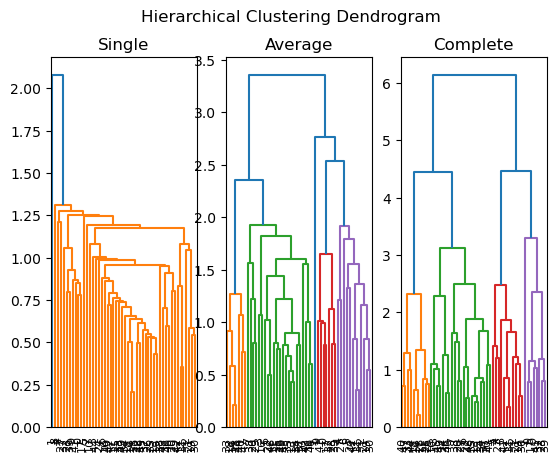

In [43]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

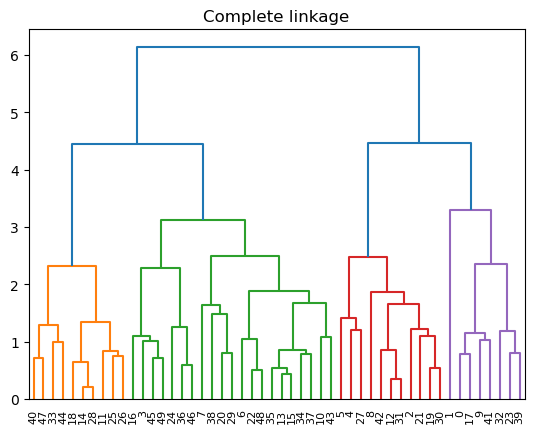

In [44]:
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index)
plt.show()

## K-means clustering

#### For our analysis, it seems that the shape of clusters is likely to be regular based on the PCA biplot. K will be set to 3. A visualisation of the clusters is shown in the figure below.

C:\Users\tshep\.conda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\tshep\.conda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


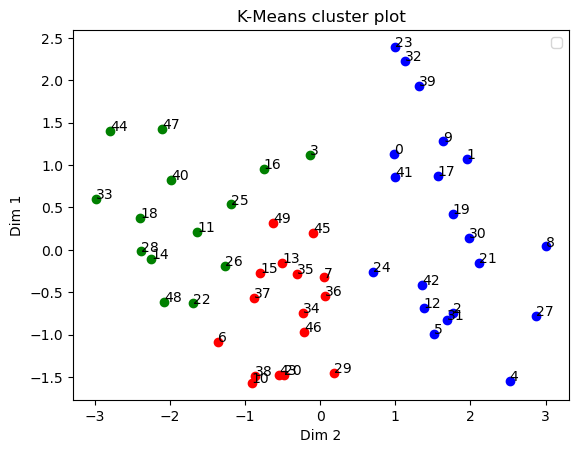

In [46]:
from sklearn.cluster import KMeans

# We extract the first two components
x = X_std_trans[:,0]
y = X_std_trans[:,1]

# Fit k-means
k=3
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = city[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Dim 2")
ax.set_ylabel("Dim 1")
ax.legend()

In [48]:
# Groups - translate to readable names
clusters = pd.DataFrame()

group0_indices = np.argwhere(cluster_labels==0).transpose()[0]
group1_indices = np.argwhere(cluster_labels==1).transpose()[0]
group2_indices = np.argwhere(cluster_labels==2).transpose()[0]

group0 = np.array(city)[group0_indices]
group1 = np.array(city)[group1_indices]
group2 = np.array(city)[group2_indices]


print("Group 0: {}\n\n".format([df.loc[x]["City"] for x in group0]))
print("Group 1: {}\n\n".format([df.loc[x]["City"] for x in group1]))
print("Group 2: {}\n\n".format([df.loc[x]["City"] for x in group2]))



Group 0: ['Connecticut', 'Delaware', 'Hawaii', 'Indiana', 'Kansas', 'Massachusetts', 'New Jersey', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'Utah', 'Virginia', 'Washington', 'Wyoming']


Group 1: ['Alabama', 'Alaska', 'Arizona', 'California', 'Colorado', 'Florida', 'Georgia', 'Illinois', 'Louisiana', 'Maryland', 'Michigan', 'Mississippi', 'Missouri', 'Nevada', 'New Mexico', 'New York', 'North Carolina', 'South Carolina', 'Tennessee', 'Texas']


Group 2: ['Arkansas', 'Idaho', 'Iowa', 'Kentucky', 'Maine', 'Minnesota', 'Montana', 'Nebraska', 'New Hampshire', 'North Dakota', 'South Dakota', 'Vermont', 'West Virginia', 'Wisconsin']


